# Module 1: Is the hourglass model for gene expression really supported by the data?
### Paper to be examined: 
“A phylogenetically based transcriptome age index mirrors ontogenetic divergence patterns”, Nature 9;468(7325):815-8 (2010)[1]
### Key claim of the paper: 
"Gene expression follows the so-called hourglass pattern observed for morphological features of development, which are most similar to each other in the phylotypic stage in mid-development."

### Schedule:
* H1: General introduction to the paper/motivation
* H2-3: Write code to import the data and start computing transcriptome age index (TAI)
* H4-6: Aim to reproduce figure 1 of the paper – help/scripts will be given if needed.
* H7: Discussion: “Are you convinced of this result? What might have gone wrong?”
* H8: Redo analysis using log-transformed data
* H9: Summarize results (e.g. on this wiki)


### Key bioinformatics concept of this module: 
"Data normalization is important and can impact the results of subsequent analyses!"


# Installation and Setup

* Install the Anaconda distribution of Python 3.x.


# Libraries
Will be using [**GEOparse**](https://geoparse.readthedocs.io/en/latest/usage.html#working-with-geo-accession) for for fetching gene expression data and [**pandas**](https://pandas.pydata.org/pandas-docs/stable/10min.html) for data manipulation and preprocessing.

In [ ]:
########### import necessary packages
import pandas as pd
import numpy as np
import GEOparse
import matplotlib.pyplot as plt

# Read gene expression data 


In [ ]:
############# Download the data
file_name = 'GSE24616'
gse = GEOparse.get_GEO(geo=file_name, destdir="./")

## GSE data structure:
Let's take a look at gene expression data stucture and accession.

**Data Sturcture:**
    - gse.gsms
        - gse.gsms.metadata
        - gse.gsms.name
        - gse.gsms.table
    - gse.gpl
        - gse.gpl.metadata
        - gse.gpl.name
        - gse.gpl.table
        
**GSE file name:** GSE24616

In [ ]:
########### Explore an example of GSE content
print ("GSM example:")
for gsm_name, gsm in gse.gsms.items():
    print ("Name: ", gsm_name)
    print ('*'*100)
    print ("Metadata:"),
    for key, value in gsm.metadata.items():
        print(" - %s : %s" % (key, ", ".join(value)))
    print('*'*100)
    print ("Table data:"),
    print (gsm.table.head())
    break

In [ ]:
print ("GPL example:")
for gpl_name, gpl in gse.gpls.items():
    print ("Name: ", gpl_name)
    print ('*'*100)
    print ("Metadata:"),
    for key, value in gpl.metadata.items():
        print (" - %s : %s" % (key, ", ".join(value)))
    print ('*'*100)
    print ("Table data:"),
    print (gpl.table.head())
    break


# Read age index data file

In [13]:
########### Read in age index data
age_index = pd.read_csv('danio_age_index.txt', sep='\t', header=None)
age_index.columns = ["GeneID","ProbeID","age"]
########### Set ProbeID as the index of dataframe
age_index.set_index('ProbeID',inplace=True)
age_index.head()

,GeneID,age
ProbeID,,
A_15_P100008,ENSDARG00000038801,1
A_15_P100011,ENSDARG00000003573,1
A_15_P100017,ENSDARG00000059855,1
A_15_P100025,ENSDARG00000021252,1
A_15_P100054,ENSDARG00000078353,1


# Pre processing gene expression data:
Gene expression data needs to be extracted from GSE data structure. Preprocessing steps are:
1. Extract the metadata
2. Extract the gene expression data
3. Add age index data to the gene expression data
4. Get average for the genes with multiple probesets
5. Select mixed and female samples 
6. Get the average gene expression for similar time points¶

## 1) Extract  metadata of samples in gene expression data
Complementary information about the samples is stores in  **gsm.metadata** including sex, developmental stage and the sample name. A sample metadata looks like:

"characteristics_ch1 : strain: wild type, developmental stage: adult, developmental timing: 1y9m, gender: mixed, number of individuals per sample: 2"

All these infomations are stored in an string and we need to extract them by some String Formatting Operations.

In [73]:
############### Extract GSE metadata
characteristics = {"stage":[],"time":[],"sex":[],"sample_name":[]}
for gsm_name, gsm in sorted(gse.gsms.items()): # gsm: metadata, columns, table
    characteristics["stage"].append(gsm.metadata['characteristics_ch1'][1].split(":")[1].strip())
    characteristics["time"].append(gsm.metadata['characteristics_ch1'][2].split(":")[1].strip())
    characteristics["sex"].append(gsm.metadata['characteristics_ch1'][3].split(":")[1].strip())
    characteristics["sample_name"].append(gsm_name)
char_df = pd.DataFrame(characteristics,index = characteristics["sample_name"])
char_df.head()

,sample_name,sex,stage,time
GSM606866,GSM606866,mixed,unfertilised egg,0min
GSM606867,GSM606867,mixed,unfertilised egg,0min
GSM606868,GSM606868,mixed,zygote,15min
GSM606869,GSM606869,mixed,zygote,15min
GSM606870,GSM606870,mixed,cleavage,45min


## 2) Extract the gene expression data

In [ ]:
############### Extract the gene expression data
data = gse.pivot_samples('VALUE') 
############# Add ProbeID as the index of gene expression dataframe
gpl = list(gse.gpls.values())[0]
data.set_index(gpl.table.SPOT_ID,inplace=True)
############ Let's look at the gene expression data
data.head()
plt.imshow(np.log(data.values),aspect='auto')
plt.show()

## 3) Add age index data to the gene expression data

In [18]:
matched_data =data.join(age_index,how='inner').groupby(level=0).last()
print("Age index data dimensios: ",age_index.shape)
print ("Gene expression data dimensions: ", data.shape)
print ("Number of genes with age index: ",matched_data.shape)


Age index data dimensios:  (16188, 2)
Gene expression data dimensions:  (45220, 147)
Number of genes with age index:  (16188, 149)


In [23]:
matched_data.sort_values(["GeneID"])

,GSM606866,GSM606867,GSM606868,GSM606869,GSM606870,GSM606871,GSM606872,GSM606873,GSM606874,GSM606875,...,GSM607005,GSM607006,GSM607007,GSM607008,GSM607009,GSM607010,GSM607011,GSM607012,GeneID,age
A_15_P210106,31.290300,55.869250,95.181910,71.704340,71.544110,70.695510,55.790740,70.272120,44.788400,60.174720,...,9.710231,28.244060,10.439500,31.252530,13.164350,29.662790,16.713900,49.035650,ENSDARG00000000001,2
A_15_P116203,15.132910,30.571520,26.151920,24.230360,16.226970,30.480700,20.268780,29.188040,16.989020,28.767230,...,500.316800,848.360300,413.796400,971.251500,389.529800,664.245700,194.885600,401.133100,ENSDARG00000000002,11
A_15_P113104,3411.686000,5403.357000,17542.150000,15811.710000,14580.950000,18592.550000,12740.700000,15646.900000,12564.050000,11623.050000,...,1756.669000,2869.057000,2510.860000,3586.206000,2202.296000,3289.721000,5808.387000,2711.892000,ENSDARG00000000018,5
A_15_P319426,115.304900,158.118400,297.548000,395.612000,318.971900,449.176600,251.954000,363.508400,220.557500,359.632500,...,385.235900,564.971900,504.634600,742.977500,249.769300,693.343100,673.050700,432.954800,ENSDARG00000000019,2
A_15_P118063,5856.425000,9483.220000,14251.290000,13209.170000,12349.150000,15857.720000,11739.600000,15955.090000,13987.420000,18430.430000,...,5202.255000,8204.282000,4894.396000,7020.545000,9841.567000,10938.940000,11340.470000,14399.920000,ENSDARG00000000068,4
A_15_P131956,4317.290000,5574.711000,3274.906000,4059.751000,2543.044000,4475.845000,2275.762000,3948.461000,2221.396000,3509.245000,...,1466.237000,3447.844000,2235.286000,4838.791000,1938.383000,2589.861000,3675.009000,3253.397000,ENSDARG00000000069,6
A_15_P115322,8863.061000,13010.570000,12038.650000,9013.499000,7222.392000,8726.668000,6659.444000,7627.565000,5662.730000,7219.858000,...,4767.904000,9595.554000,5759.378000,13555.640000,5504.764000,7606.090000,10743.260000,9593.306000,ENSDARG00000000069,6
A_15_P119238,16.450730,9.894705,27.510430,38.287040,31.968170,35.012130,29.977800,46.907590,25.131000,51.157080,...,11.702700,29.680740,14.044180,21.164250,18.207360,23.795530,25.668060,31.255340,ENSDARG00000000086,1
A_15_P157451,2.029716,1.630225,1.744133,14.890730,1.782333,6.800075,1.531715,3.334878,1.549516,3.498886,...,34.664410,81.985180,58.145550,84.027540,47.401120,128.689100,24.222550,32.919910,ENSDARG00000000102,1
A_15_P130646,5.883150,7.087420,6.013478,15.799160,2.540749,8.957662,4.185797,10.494210,2.721384,5.581195,...,26.925070,36.054420,26.257150,31.563880,17.170890,48.687450,8.334457,28.327330,ENSDARG00000000102,1


## 4) Get average for the genes with multiple probesets

In [28]:
########### Average out multiple transcripts
unique_data = matched_data.groupby('GeneID').mean()
print ("Number of unique transcripts: ",unique_data.shape[0])

Number of unique transcripts:  12892


## 5) Select mixed and female samples

In [74]:
char_df= char_df[char_df["sex"]!="male"]


## 6) Get the average gene expression for similar time points

In [78]:
########## find samples of the same time points

experiment_index=[]
time_stamps = char_df.time.unique()
for t in time_stamps:
    experiment_index.append(char_df[char_df['time']==t].index.tolist())
########### average the samples for similar time points
set_mean = {}
stages = []
timestamps=[]
for d in range(len(experiment_index)) :
    sample_list = experiment_index[d]
    set_mean[d] = unique_data[sample_list].mean(axis=1)
    stages.append(char_df[char_df.index.isin(sample_list)].stage[0])
    timestamps.append(char_df[char_df.index.isin(sample_list)].time[0])
mean_data = pd.DataFrame(set_mean )
mean_data.columns= stages
mean_data.head()

,unfertilised egg,zygote,cleavage,cleavage,cleavage,blastula,blastula,blastula,blastula,blastula,...,juvenile,juvenile,adult,adult,adult,adult,adult,adult,adult,adult
GeneID,,,,,,,,,,,,,,,,,,,,,
ENSDARG00000000001,43.579775,83.443125,71.119810,63.03143,60.628190,49.01749,49.549605,43.79437,33.41657,32.97779,...,43.74697,53.750925,50.525365,45.79091,66.605335,108.772475,93.719485,114.51177,114.384435,34.181425
ENSDARG00000000002,22.852215,25.191140,23.353835,24.72841,26.720193,39.59848,39.728450,35.82690,26.27642,22.81932,...,746.71440,540.680800,597.622950,573.15160,400.438450,385.692150,463.057400,411.58645,354.381250,455.134075
ENSDARG00000000018,4407.521500,16676.930000,16586.750000,14193.80000,13119.660000,16973.08500,16721.610000,11987.34000,10809.15350,12519.80500,...,5769.60250,7716.946500,7921.420000,10432.38250,11508.055000,18600.865000,10988.534000,14121.77000,15040.460000,8207.264750
ENSDARG00000000019,136.711650,346.580000,384.074250,307.73120,341.886633,337.51405,333.049150,259.48750,227.49525,247.80375,...,634.64195,911.222950,960.104900,1281.17205,1694.315500,2732.318500,1166.058450,2106.93150,2243.022000,1569.307375
ENSDARG00000000068,7669.822500,13730.230000,14103.435000,13847.34500,17017.293333,16465.23500,15704.555000,13742.96000,12857.69000,12257.20500,...,21274.32500,17284.360000,13999.060000,14570.68500,15822.270000,21657.840000,16054.155000,18389.46000,19896.755000,10289.684250


# TAI Calculation

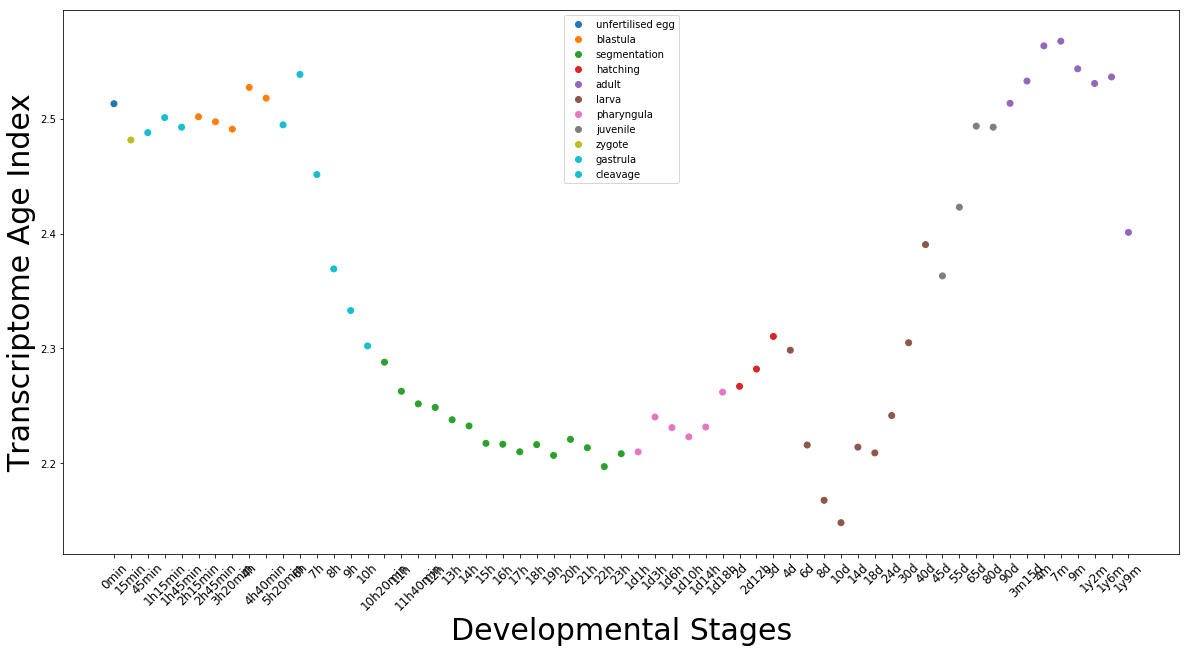

In [54]:
########### Calculating TAI
import matplotlib
age_indices =unique_data['age']
expression_data = mean_data.values
product = np.dot(expression_data.T,age_indices)
mean_expression = expression_data.T.sum(1)
TAI = np.divide(product,mean_expression)

#### define color map

unique_stages= list(set(stages))
color_list = plt.cm.tab10(np.linspace(0, 1, len(unique_stages))) 
color = {unique_stages[i]:color_list[i] for i in range(len(unique_stages))}
my_col= [color[i] for i in stages]

plt.figure(figsize=(20,10))
plt.scatter(range(len(TAI)),TAI,color=my_col,linestyle='-')
plt.xticks(range(len(TAI)),timestamps,rotation=45,size=12)
plt.ylabel("Transcriptome Age Index",size=30)
plt.xlabel("Developmental Stages",size=30)
markers = [plt.Line2D([0,0],[0,0],color=c, marker='o', linestyle='') for c in color.values()]
plt.legend(markers,color.keys(),loc='upper center')
plt.savefig('TAI.png')
plt.show()


# Save the pre-processed expression data to a file